## setup

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, LinearSegmentedColormap
import seaborn as sns

In [ ]:
#file_path = "detailed_analysis.jsonl"
#file_path = "seq_detailed_analysis.jsonl"
file_path = "tree_detailed_analysis.jsonl"
depth = 64

## function

In [27]:
def read_jsonl_file(file_path):
    data_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            json_object = json.loads(line)
            data_list.append(json_object)
  
    return data_list

In [28]:
# make probs to cumulative probs
# cumulative: prob[i] = prob[i] * prob[i-1] * prob[i-2] * ... * prob[0]
# return as probs (list)
def cumulative_probs(probs):
    temp_probs = probs[0]
    cum_probs = []
    cum_prob = 1.0
    for p in temp_probs:
        cum_prob *= p
        cum_probs.append(cum_prob)
    return [cum_probs, probs[1]]

In [29]:
def pre_processing(sample_list, depth, types='full'):
    X_Accept = []
    Y_Accept = []
    X_Reject = []
    Y_Reject = []

    total_count = 0
    count = 0

    for sample in sample_list:
        for data in sample:
            if "cumulative" in types: 
                #print("before cum:", data, len(data))
                data = cumulative_probs(data)
                #print("after cum:", data, len(data))
            # cut samples deeper than specified depth
            data_length = len(data[0])
            acc_length = data[1]
            #data[0] = data[0][:depth]
            data[1] = min(data[1], depth)
            total_count += 1
            if data_length == acc_length + 1:
                # last one is rejected
                # add accepted
                X_Accept.extend(data[0][:data[1]])
                Y_Accept.extend(range(1, data[1]+1))
                if data[1] < depth:
                    # add rejected if within depth
                    X_Reject.append(data[0][data[1]])
                    Y_Reject.append(data[1]+1)
            else:
                # all accepted
                count += 1
                if 'skip32' in types:
                    continue
                # Accept all
                # Get a min depth 
                min_range = min(len(data[0]), data[1])
                X_Accept.extend(data[0][:min_range])
                Y_Accept.extend(range(1, min(min_range, data[1])+1))

    print(f"Acceptance Rate: {count}/{total_count} = {count/total_count:.2%}")

    return X_Accept, Y_Accept, X_Reject, Y_Reject

In [30]:
def draw_scatter_plot(X_Accept, Y_Accept, X_Reject, Y_Reject):
    plt.figure(figsize=(20, 6))

    plt.scatter(X_Accept, Y_Accept, color='#4C72B0', label='Accept', s=20, alpha=0.4)
    plt.scatter(X_Reject, Y_Reject, color='#C44E52', label='Reject', s=20, alpha=0.4)

    plt.xlim(0.3, 1)
    plt.xticks(np.arange(0.3, 1.1, 0.1))
    plt.ylim(0.5, depth+0.5)
    plt.yticks(np.arange(1.0, depth+1, 2.0))

    plt.xlabel('Probability', fontsize=18)
    plt.ylabel('Depth', fontsize=18)
    plt.title('Scatter Plot of Depth vs Probability', fontsize=20)
    plt.legend()

    plt.show()

In [31]:
def draw_histogram_prob(X_Accept, X_Reject):
    plt.figure(figsize=(10, 6))

    bin_edges = np.arange(0.0, 1.1, 0.1)

    X_Total = X_Accept + X_Reject
    total_count, _ = np.histogram(X_Total, bins=bin_edges)
    accept_count, _ = np.histogram(X_Accept, bins=bin_edges)
    reject_count, _ = np.histogram(X_Reject, bins=bin_edges)
    accept_normalized = accept_count / total_count
    reject_normalized = reject_count / total_count
    
    plt.bar(bin_edges[:-1], accept_normalized, width=0.1, color='#4C72B0', alpha=0.8, label='Accept', align='edge')
    plt.bar(bin_edges[:-1], reject_normalized, width=0.1, color='#C44E52', alpha=0.8, label='Reject', align='edge', bottom=accept_normalized)

    plt.xlim(0, 1)
    plt.xticks(np.arange(0.0, 1.1, 0.1))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Probability', fontsize=14)
    plt.ylabel('Sample Proportion', fontsize=14)
    plt.title('Probability Distribution by Acceptance Status', fontsize=16)
    plt.legend()

    plt.show()

In [32]:
def draw_histogram_depth(Y_Accept, Y_Reject, depth, zoom_min=0.85):
    """
    Plots two stacked bar charts showing the accept/reject proportion at different depths.

    1. Full range (0.0 - 1.0)
    2. Zoomed-in top (zoom_min - 1.0)

    Parameters:
    Y_Accept (array-like): Array containing the depths of all 'Accept' events.
    Y_Reject (array-like): Array containing the depths of all 'Reject' events.
    depth (int): The maximum depth to plot.
    zoom_min (float): The minimum y-axis value for the second, zoomed-in plot (e.g., 0.85).
    """
    
    # Define the bin edges for depth (e.g., for depth=8, edges are [0.5, 1.5, ..., 8.5])
    # Use depth + 1.5 to ensure the bin for 'depth' is included
    bin_edges = np.arange(0.5, depth + 1.5, 1.0)

    # Calculate the counts in each bin
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    reject_count, _ = np.histogram(Y_Reject, bins=bin_edges)
    
    # Calculate total counts (corrected logic)
    total_count = accept_count + reject_count

    # Normalize proportions (safely handling division by zero)
    accept_normalized = np.divide(accept_count, total_count, 
                                  out=np.zeros_like(accept_count, dtype=float), 
                                  where=total_count!=0)
    reject_normalized = np.divide(reject_count, total_count, 
                                  out=np.zeros_like(reject_count, dtype=float), 
                                  where=total_count!=0)

    # Bins for plotting (using the left edge of the bins)
    plot_bins = bin_edges[:-1]

    plt.figure(figsize=(10, 7))
    
    # Plot the stacked bars
    plt.bar(plot_bins, accept_normalized, width=1.0, color='#4C72B0', alpha=0.8, label='Accept', align='edge')
    plt.bar(plot_bins, reject_normalized, width=1.0, color='#C44E52', alpha=0.8, label='Reject', align='edge', bottom=accept_normalized)

    # Formatting
    plt.xlim(0.5, depth + 0.5) # Ensure x-axis shows all bars
    plt.xticks(np.arange(1, depth + 1, 2))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Depth', fontsize=14)
    plt.ylabel('Sample Proportion', fontsize=14)
    plt.title('Depth Distribution by Acceptance Status', fontsize=16)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 7))
    
    # Plot the same stacked bars
    plt.bar(plot_bins, accept_normalized, width=1.0, color='#4C72B0', alpha=0.8, label='Accept', align='edge')
    plt.bar(plot_bins, reject_normalized, width=1.0, color='#C44E52', alpha=0.8, label='Reject', align='edge', bottom=accept_normalized)

    # Formatting (Zoomed)
    plt.xlim(0.5, depth + 0.5)
    plt.xticks(np.arange(1, depth + 1, 2))
    
    # Apply the y-axis zoom
    plt.ylim(zoom_min, 1.0) 
    
    # Automatically calculate zoomed y-ticks (e.g., 5 intervals)
    plt.yticks(np.linspace(zoom_min, 1.0, 6)) # 6 points = 5 intervals

    plt.xlabel('Depth', fontsize=14)
    plt.ylabel('Sample Proportion', fontsize=14)
    plt.title(f'Depth Distribution by Acceptance Status (Zoomed {zoom_min:.0%}-100%)', fontsize=16)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [33]:
def draw_histogram_cumulative_depth(Y_Accept, Y_Reject, depth):
    sns.set_theme(style="darkgrid")
    
    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    bin_edges = np.arange(0.5, depth + 1.5, 1.0)
    x_values = bin_edges[:-1] # x-axis positions for the bars (0.5, 1.5, ...)

    Y_Total = Y_Accept + Y_Reject
    
    total_count, _ = np.histogram(Y_Total, bins=bin_edges)
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    
    # Avoid divide-by-zero errors
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_accept_at_depth = accept_count / total_count
    
    # If total_count at a certain depth is 0, we assume its acceptance rate is 1.0
    # This is to replicate the implicit behavior of your original code
    # `accept_normalized[i] *= accept_normalized[i-1]` in case of NaN.
    prob_accept_at_depth[total_count == 0] = 1.0

    # Calculate Cumulative Acceptance Rate (Cumulative Product)
    cumulative_accept_prob = np.cumprod(prob_accept_at_depth)
    
    # Cumulative Reject Rate
    cumulative_reject_prob = 1 - cumulative_accept_prob

    # Plot the bars
    # Use softer colors
    ax.bar(x_values, cumulative_accept_prob, width=1.0, color='#4C72B0', alpha=0.8, label='Accept', align='edge')
    ax.bar(x_values, cumulative_reject_prob, width=1.0, color='#C44E52', alpha=0.8, label='Reject', align='edge', bottom=cumulative_accept_prob)

    ax.set_xlim(0.5, depth + 0.5)
    
    # Dynamically adjust x-axis ticks to avoid overcrowding
    tick_step = max(1, depth // 20) # Try to show about 20 ticks
    ax.set_xticks(np.arange(1, depth + 1, tick_step))
    
    ax.set_ylim(0, 1.0)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))

    ax.set_xlabel('Depth', fontsize=14)
    ax.set_ylabel('Sample Proportion', fontsize=14)
    ax.set_title('Cumulative Depth Distribution by Acceptance Status', fontsize=16)
    
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

In [34]:
def draw_cumulative_line_charts(Y_Accept, Y_Reject, depth):
    """
    Draws two versions of the "Cumulative Depth Distribution" line chart.
    1. Single curve chart (with filled area)
    2. Dual curve comparison chart
    """
    sns.set_theme(style="darkgrid")
    
    bin_edges = np.arange(0.5, depth + 1.5, 1.0)
    # For line charts, we use the bin centers or left edges (here, 1, 2, 3...)
    x_values = np.arange(1, depth + 1)

    Y_Total = Y_Accept + Y_Reject
    
    total_count, _ = np.histogram(Y_Total, bins=bin_edges)
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_accept_at_depth = accept_count / total_count
    
    prob_accept_at_depth[total_count == 0] = 1.0

    cumulative_accept_prob = np.cumprod(prob_accept_at_depth)
    cumulative_reject_prob = 1 - cumulative_accept_prob
    
    # Create a 1x2 subplot canvas
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    fig.suptitle('Cumulative Depth Distribution', fontsize=22, y=1.02)

    # --- Chart 1: Single Curve (Red/Blue Boundary) + Fill ---
    ax1 = axes[0]
    # Plot the boundary line
    ax1.plot(x_values, cumulative_accept_prob, 
             color='#1F77B4', # Use a darker blue
             marker='o', 
             markersize=3, 
             linestyle='-', 
             label='Cumulative Accept Proportion')
    
    # Fill the upper and lower areas
    ax1.fill_between(x_values, 0, cumulative_accept_prob, color='#4C72B0', alpha=0.3, label='Accept Area')
    ax1.fill_between(x_values, cumulative_accept_prob, 1, color='#C44E52', alpha=0.3, label='Reject Area')
    
    ax1.set_title('Cumulative Accept Proportion Curve', fontsize=20)
    ax1.set_xlabel('Depth', fontsize=18)
    ax1.set_ylabel('Sample Proportion', fontsize=18)
    ax1.set_xlim(1, depth)
    ax1.set_ylim(0, 1.05)
    ax1.legend(loc='lower left', fontsize=16)

    # --- Chart 2: Dual Curve (Accept vs. Reject) ---
    ax2 = axes[1]
    ax2.plot(x_values, cumulative_accept_prob, 
             color='#4C72B0', 
             marker='.', 
             linestyle='--', 
             label='Cumulative Accept')
    
    ax2.plot(x_values, cumulative_reject_prob, 
             color='#C44E52', 
             marker='.', 
             linestyle=':', 
             label='Cumulative Reject')
    
    ax2.set_title('Cumulative Accept vs. Reject Curve', fontsize=20)
    ax2.set_xlabel('Depth', fontsize=18)
    ax2.set_ylabel('Sample Proportion', fontsize=18)
    ax2.set_xlim(1, depth)
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc='upper right', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [35]:
def draw_tau_line_charts(Y_Accept, Y_Reject, depth):
    """
    Plot two cumulative charts:
    1. Cumulative Expected Accepted Tokens
    2. Cumulative Accept Proportion (Survival Curve)
    """
    
    # Use seaborn style
    sns.set_theme(style="darkgrid")
    
    # --- Core calculation logic ---
    bin_edges = np.arange(0.5, depth + 1.5, 1.0)
    # X-axis (depth 1, 2, 3...)
    x_values = np.arange(1, depth + 1)

    Y_Total = Y_Accept + Y_Reject
    
    total_count, _ = np.histogram(Y_Total, bins=bin_edges)
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        # g(n): Conditional probability of accepting at depth n
        prob_accept_at_depth = accept_count / total_count
    
    # Handle division by zero
    prob_accept_at_depth[total_count == 0] = 1.0

    # P_s(n): Probability of surviving to depth n (P_survive)
    cumulative_accept_prob = np.cumprod(prob_accept_at_depth)
    # --- End of core logic ---
    
    
    # --- ✨ Calculate Cumulative Expected Accepted Tokens f(n) ---
    # f(n) = sum_{i=1 to n} P_s(i)
    # This is the new Y-axis data (tau)
    cumulative_expected_accepts = np.cumsum(cumulative_accept_prob)
    # --- End of calculation ---
    

    # Create a 1x2 subplot canvas
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    
    fig.suptitle('Token Acceptance Analysis (τ vs. Survival Probability)', fontsize=22, y=1.02)

    # --- Plot 1: Cumulative Expected Accepted Tokens (τ) ---
    ax1 = axes[0]
    ax1.plot(x_values, cumulative_expected_accepts, 
             color='#0072B2', # (Dull Blue)
             marker='o', 
             markersize=4, 
             linestyle='-', 
             label='Cumulative Expected Accepted Tokens')
    
    ax1.set_title('Cumulative Expected Accepted Tokens (τ(n))', fontsize=20)
    ax1.set_xlabel('Depth (n)', fontsize=18)
    ax1.set_ylabel('Expected Tokens (τ)', fontsize=18)
    ax1.set_xlim(1, depth)
    # Y-axis upper limit auto-adjusts (can be > 1)
    ax1.set_ylim(bottom=0) 
    ax1.legend(loc='upper left', fontsize=16)
    ax1.grid(True, linestyle='--')

    # --- Plot 2: Cumulative Accept Proportion (Survival Curve) ---
    # (This plot is for comparison, showing P_survive)
    ax2 = axes[1]
    # Plot the boundary line
    ax2.plot(x_values, cumulative_accept_prob, 
             color='#1F77B4', # (Darker Blue)
             marker='o', 
             markersize=3, 
             linestyle='-', 
             label='Cumulative Accept Proportion (P_survive)')
    
    # Fill areas above and below
    ax2.fill_between(x_values, 0, cumulative_accept_prob, color='#4C72B0', alpha=0.3, label='Accept Area')
    ax2.fill_between(x_values, cumulative_accept_prob, 1, color='#C44E52', alpha=0.3, label='Reject Area')
    
    ax2.set_title('Cumulative Accept Proportion (Survival Probability)', fontsize=20)
    ax2.set_xlabel('Depth (n)', fontsize=18)
    ax2.set_ylabel('Sample Proportion (P_survive)', fontsize=18)
    ax2.set_xlim(1, depth)
    ax2.set_ylim(0, 1.05)
    ax2.legend(loc='lower left', fontsize=16)
    ax2.grid(True, linestyle='--')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

In [36]:
def draw_heatmap(X_Accept, Y_Accept, X_Reject, Y_Reject, depth):
    """
    Plots a red-blue heatmap where:
    - Darkness (white to dark) represents total count (Accept + Reject)
    - Hue (red to blue) represents the ratio of Reject vs Accept
    
    Updated to use custom colors:
    - Reject Color: #C44E52
    - Accept Color: #4C72B0
    """
    
    plt.rcParams['axes.unicode_minus'] = False 
    plt.figure(figsize=(10, 6), facecolor='white')

    # Define bins for X-axis (Probability) and Y-axis (Depth)
    prob_bins = np.arange(0.0, 1.1, 0.05)
    depth_bins = np.arange(1.0, depth + 2.0, 1.0) # Y-axis bins need N+1 edges

    # Compute 2D histograms
    Count_Accept, _, _ = np.histogram2d(X_Accept, Y_Accept, bins=[prob_bins, depth_bins])
    Count_Reject, _, _ = np.histogram2d(X_Reject, Y_Reject, bins=[prob_bins, depth_bins])

    # Transpose matrices, so Y-axis (Depth) becomes the first dimension (row)
    Count_Accept = Count_Accept.T
    Count_Reject = Count_Reject.T    
    Total_Count = Count_Accept + Count_Reject

    # 1. Calculate Darkness, normalized by Prob dimension (column)
    
    # Find the max count for each "Prob" column (along depth axis, axis=0)
    max_count_per_prob = np.amax(Total_Count, axis=0) # Shape: (num_prob_bins,)

    # Use log1p transform as well
    log_Total_Count = np.log1p(Total_Count)
    log_max_per_prob = np.log1p(max_count_per_prob) # Shape: (num_prob_bins,)
    
    # Perform division, log_Total_Count[i, j] / log_max_per_prob[j]
    # Use broadcasting and np.divide to handle division by zero
    Darkness = np.divide(log_Total_Count, 
                         log_max_per_prob, 
                         out=np.zeros_like(log_Total_Count, dtype=float), 
                         where=log_max_per_prob != 0)
    
    # Darkness is now a value from 0.0 to 1.0, representing its
    # relative intensity *within its column*

    # 2. Calculate Hue Proportions
    # Handle division by zero (NaN) when Total_Count is 0
    Prop_Reject = np.divide(Count_Reject, Total_Count, 
                            out=np.zeros_like(Total_Count, dtype=float), 
                            where=Total_Count!=0)
    Prop_Accept = np.divide(Count_Accept, Total_Count, 
                            out=np.zeros_like(Total_Count, dtype=float), 
                            where=Total_Count!=0)

    # 3. Mix RGB Channels

    # Define target colors (scaled 0.0 to 1.0)
    # Reject Color (#C44E52)
    Reject_Color_RGB = (196/255.0, 78/255.0, 82/255.0)
    # Accept Color (#4C72B0)
    Accept_Color_RGB = (76/255.0, 114/255.0, 176/255.0)

    # Calculate the "Target Color" by mixing Reject and Accept based on proportion
    # Target_Color = Prop_Reject * Reject_Color + Prop_Accept * Accept_Color
    Target_R = Prop_Reject * Reject_Color_RGB[0] + Prop_Accept * Accept_Color_RGB[0]
    Target_G = Prop_Reject * Reject_Color_RGB[1] + Prop_Accept * Accept_Color_RGB[1]
    Target_B = Prop_Reject * Reject_Color_RGB[2] + Prop_Accept * Accept_Color_RGB[2]

    # Now, interpolate from White to the Target_Color based on Darkness
    # Final_Color = (1.0 - Darkness) * White + Darkness * Target_Color
    # White = (1.0, 1.0, 1.0)
    R_Channel = (1.0 - Darkness) * 1.0 + Darkness * Target_R
    G_Channel = (1.0 - Darkness) * 1.0 + Darkness * Target_G
    B_Channel = (1.0 - Darkness) * 1.0 + Darkness * Target_B
    
    # Stack the three channels into an RGB image
    # np.stack adds a new dimension at the end (axis=-1)
    rgb_image = np.stack([R_Channel, G_Channel, B_Channel], axis=-1)

    # --- Plotting ---
    plt.imshow(
        rgb_image, 
        interpolation='nearest',
        origin='lower',
        aspect='auto', # let cells adapt to the canvas
        extent=[prob_bins[0], prob_bins[-1], depth_bins[0], depth_bins[-1]] # ensure correct axis coordinates
    )

    # X-axis labels (Probability)
    # We are using extent, so we can set ticks directly
    plt.xticks(prob_bins[::4], [f"{x:.2f}" for x in prob_bins[::4]])
    
    # Y-axis labels (Depth)
    # Y-axis bin labels should be 1, 2, ..., depth
    # We place the tick in the middle of each bin
    all_tick_locations_y = depth_bins[:-1] + 0.5
    all_tick_labels_y = depth_bins[:-1] # These are the numerical values 1.0 to depth

    # Select ~10 ticks, including first and last
    num_ticks_y = 10 
    
    # Generate indices for ticks, ensuring we include index 0 and index (depth - 1)
    # This selects ~10 indices evenly spaced from 0 to (depth - 1)
    tick_indices = np.linspace(0, depth - 1, num=num_ticks_y, dtype=int)
    
    # Handle case where depth < num_ticks_y, linspace might produce duplicates
    # np.unique ensures we only get one of each index
    tick_indices = np.unique(tick_indices) 

    # Select the locations and labels based on these indices
    final_tick_locations_y = all_tick_locations_y[tick_indices]
    final_tick_labels_y = [f"{all_tick_labels_y[i]:.0f}" for i in tick_indices]
    
    plt.yticks(final_tick_locations_y, final_tick_labels_y)

    plt.xlabel('Probability')
    plt.ylabel('Depth')
    plt.title('Heatmap of Depth vs Probability (Red=Reject, Blue=Accept)')
    
    # Add a Colorbar as a reference
    # Create a gradient using our custom colors
    colors = [Reject_Color_RGB, (1, 1, 1), Accept_Color_RGB] # Reject -> White -> Accept
    cmap_gradient = LinearSegmentedColormap.from_list("CustomRedWhiteBlue", colors, N=256)

    plt.colorbar(plt.cm.ScalarMappable(norm=Normalize(vmin=-1, vmax=1), 
                                        cmap=cmap_gradient), 
                 ax=plt.gca(),
                 label='<- More Reject | More Accept ->',
                 ticks=[-1, 0, 1])

    plt.tight_layout()
    plt.show()

## Main

Acceptance Rate: 1393/2388 = 58.33%
X_Accept length: 37053
X_Reject length: 115
Y_Accept length: 37053
Y_Reject length: 115


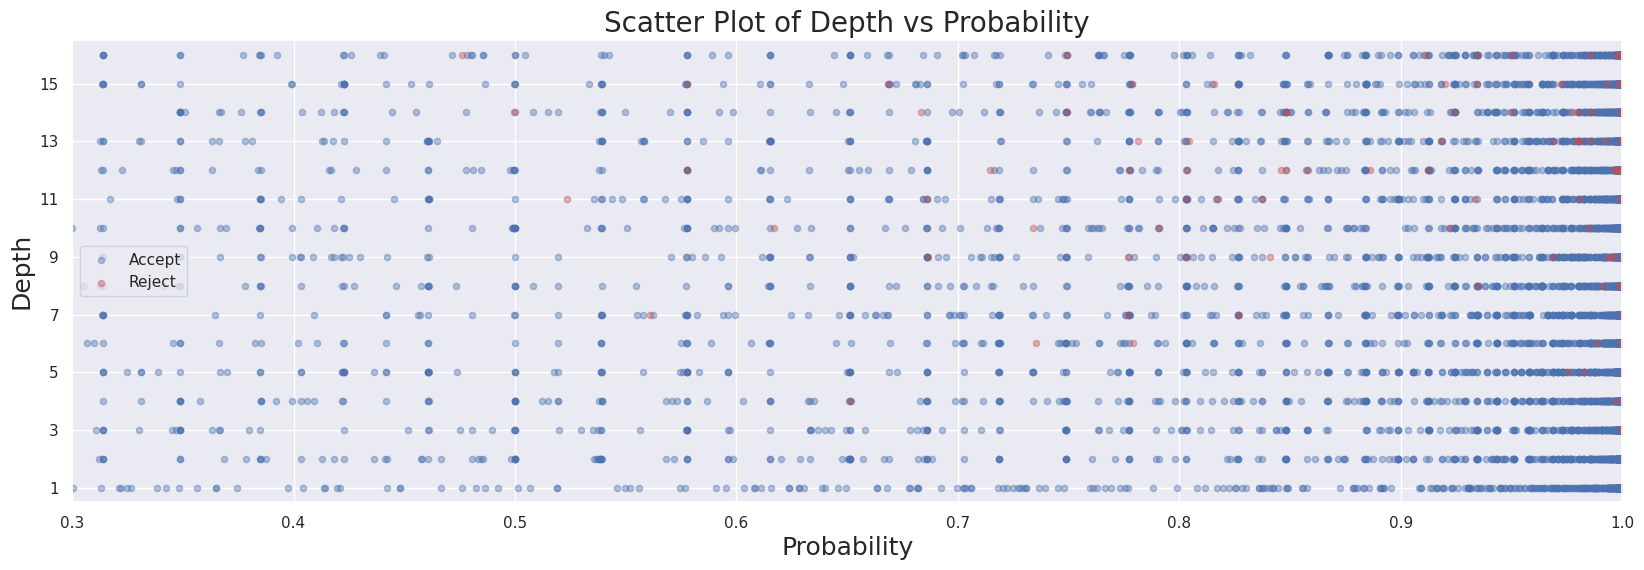

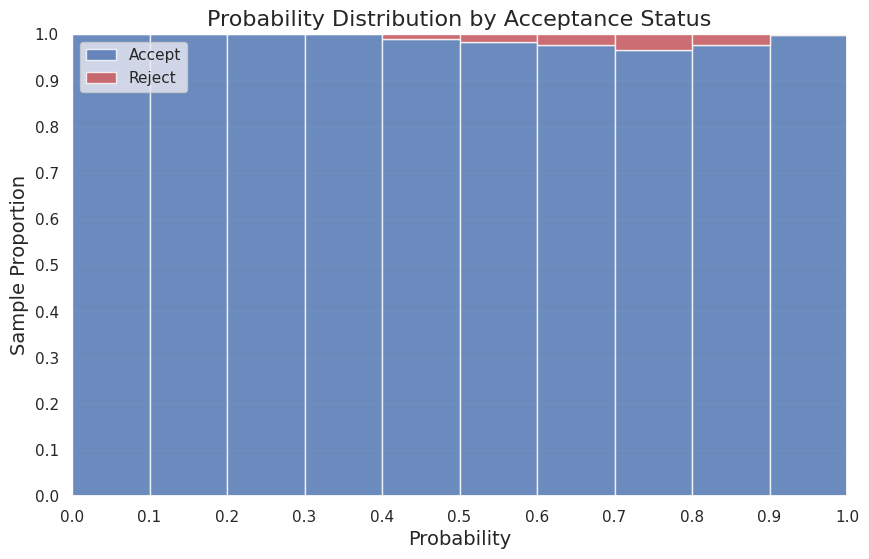

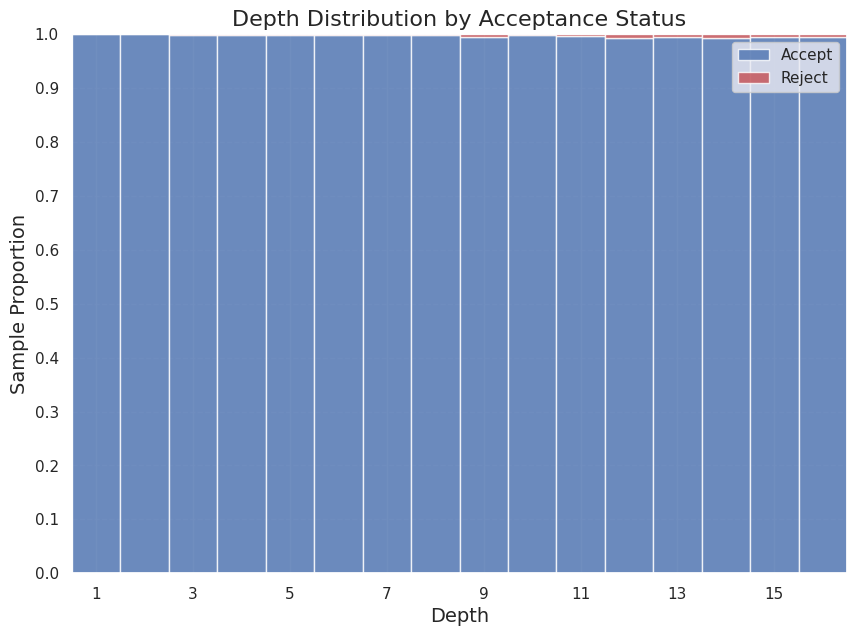

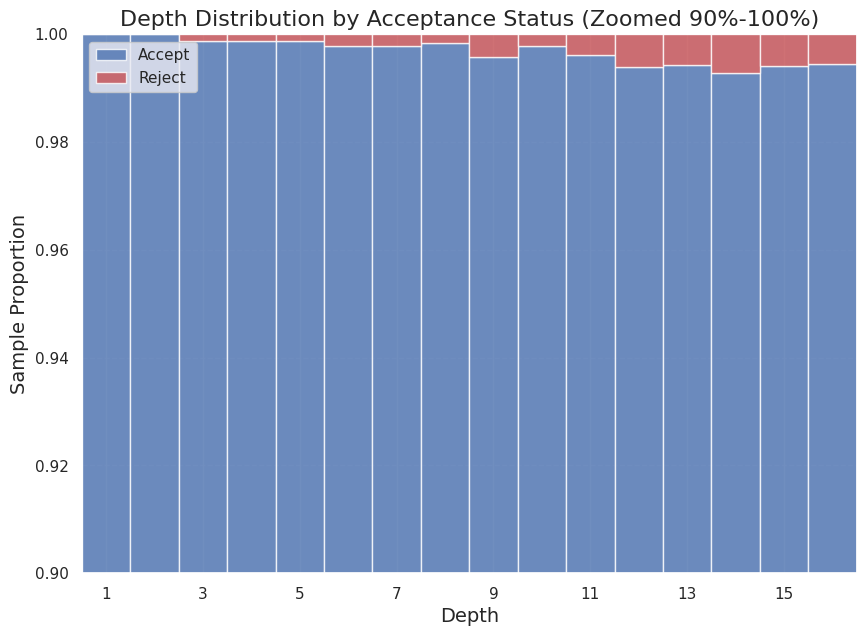

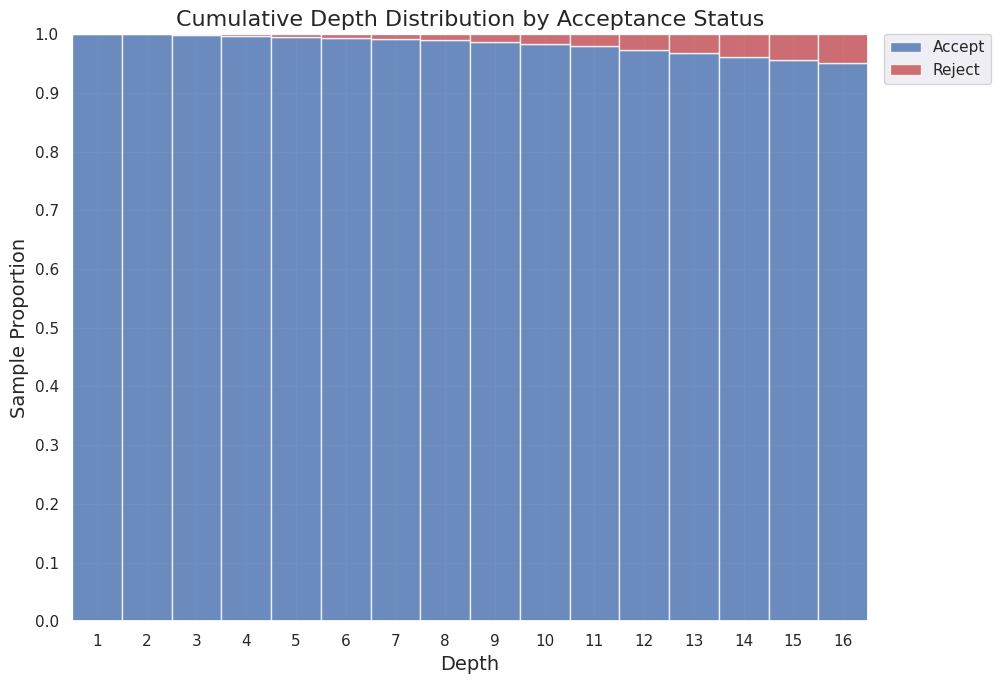

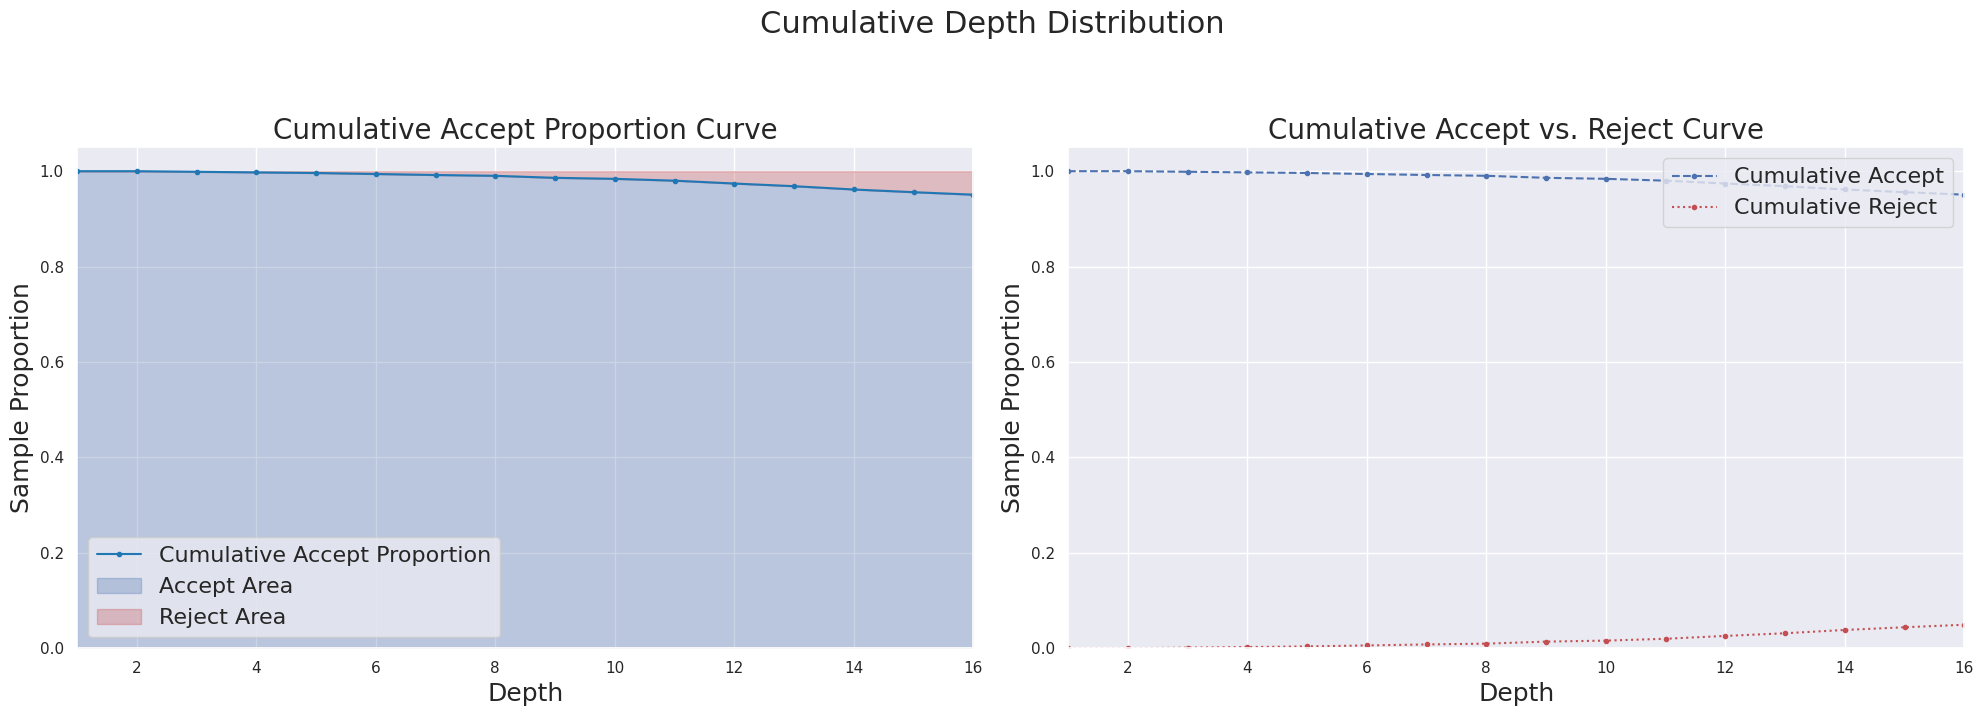

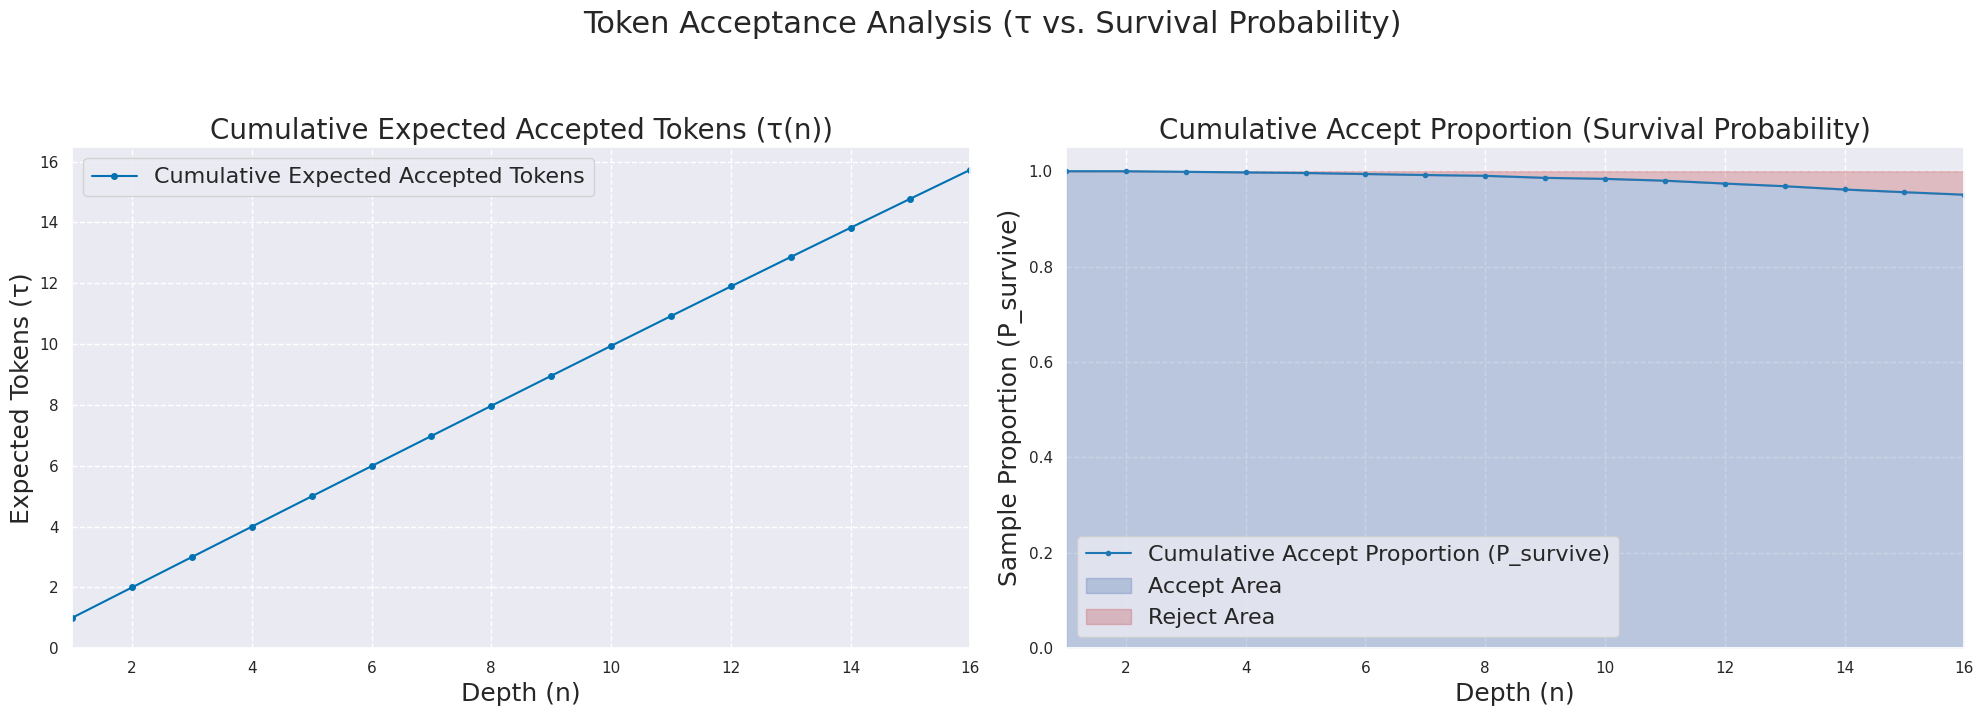

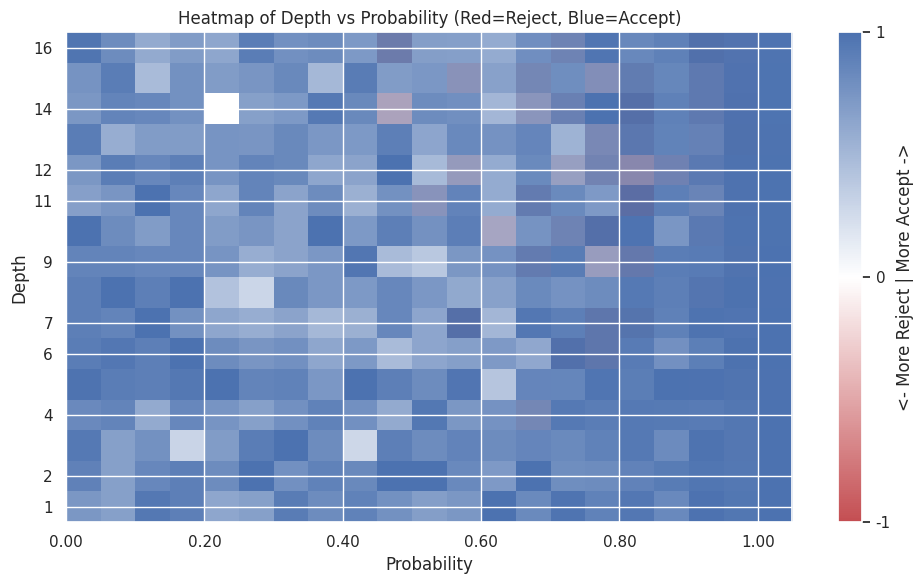

In [37]:
sample_list = read_jsonl_file(file_path)

# X: Probability, Y: Depth
# X_Accept, Y_Accept, X_Reject, Y_Reject = pre_processing(sample_list, depth, types='skip32')
# draw_scatter_plot(X_Accept, Y_Accept, X_Reject, Y_Reject)
# draw_histogram_prob(X_Accept, X_Reject)
# draw_histogram_depth(Y_Accept, Y_Reject, depth)

# X_Accept, Y_Accept, X_Reject, Y_Reject = pre_processing(sample_list, depth, types='cumulative')
# print("X_Accept length:", len(X_Accept))
# print("X_Reject length:", len(X_Reject))
# print("Y_Accept length:", len(Y_Accept))
# print("Y_Reject length:", len(Y_Reject))

X_Accept, Y_Accept, X_Reject, Y_Reject = pre_processing(sample_list, depth, types='full')
print("X_Accept length:", len(X_Accept))
print("X_Reject length:", len(X_Reject))
print("Y_Accept length:", len(Y_Accept))
print("Y_Reject length:", len(Y_Reject))

draw_scatter_plot(X_Accept, Y_Accept, X_Reject, Y_Reject)
draw_histogram_prob(X_Accept, X_Reject)
draw_histogram_depth(Y_Accept, Y_Reject, depth, zoom_min=0.90)
draw_histogram_cumulative_depth(Y_Accept, Y_Reject, depth)
draw_cumulative_line_charts(Y_Accept, Y_Reject, depth)
draw_tau_line_charts(Y_Accept, Y_Reject, depth)
draw_heatmap(X_Accept, Y_Accept, X_Reject, Y_Reject, depth)